In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean
import warnings
import os
import sys
import dask.array as da

In [2]:
def BSSCalpath(mods,is_detrend,years,il,tag,region='NPac'):
    basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
    # Input/output directory
    mhwdir = basepath+'/mhw/detrended' if is_detrend else basepath+'/mhw'
    if is_detrend:
        f_save = f'{mhwdir}/BSS_{tag}_MME_{"_".join(mods)}_l{il}_detrended_{years[0]}_{years[1]}.nc'
    else:
        f_save = f'{mhwdir}/BSS_{tag}_MME_{"_".join(mods)}_l{il}_{years[0]}_{years[1]}.nc'
    return f_save

In [3]:
mods='CanSIPSv3'
is_detrend=1
years = [1991, 2020]
il=1
tag='PXGF'

In [4]:
lonW=-170+360
lonE=-110+360
latS=35
latN=65
iP0=20;iP1=-10;jP0=10 # cutoff at beginning of arrays to match parametric area
basepath='/space/hall5/sitestore/eccc/crd/ccrn/users/reo000/work/MHW'
# Input/output directory
if is_detrend:
    #mhwdir = basepath+'/mhw/detrended';
    f_obs = basepath+f'/OISST/mhw_detrended_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
else:
    #mhwdir = basepath+'/mhw';
    f_obs = basepath+f'/OISST/mhw_oisst-avhrr-v02r01.regridded1x1.monthly.{years[0]}_{years[-1]}.nc'
fobs=xr.open_dataset(f_obs).sel(X=slice(lonW,lonE),Y=slice(latS,latN))

if not mods=='CanSIPSv3':
    raise Exception('Parametric Not Available')

if is_detrend:
    ffor=xr.open_dataset(f'/space/hall5/sitestore/eccc/crd/ccrn/users/rjj000/s2d_calibration/MHW_lead{il}/Data/{tag}-PE_lead{il}.nc')
else:
    raise Exception('non-detrended calibrated forecasts not run yet')
#ffor=xr.open_mfdataset(flist,chunks={'X':10,'Y':10,'M':-1},concat_dim='M',combine='nested',data_vars='minimal',
#                   coords='minimal',parallel=True,preprocess=lambda f: f.drop_vars(["sst_an_thr","mhw_prob"]))
#M0=xr.where(np.isnan(ffor.is_mhw),0,1).sum(dim='M').mean(dim='S')
# reshape calibrated forecast array to match obs shape
form=np.empty([len(ffor.init_year)*len(ffor.init_month),len(ffor.latitude),len(ffor.longitude)])
for iy in range(0,len(ffor.init_year)):
    for im in range(0,len(ffor.init_month)):
        form[iy*12+im,:,:]=ffor.sst_an_dt[1,:,:,im,iy].values

if il==0:
    mhwfor=form
    mhwobs=fobs.is_mhw.data[:,jP0:,iP0:iP1]
else:
    mhwfor=form[:(-1*il),...]
    mhwobs=fobs.is_mhw.data[il:,jP0:,iP0:iP1]

BrS=np.sum((mhwfor-mhwobs)**2,axis=0)/mhwobs.shape[0]
BrSref=da.sum((.1-mhwobs)**2,axis=0)/mhwobs.shape[0]
BSS=1-BrS/BrSref
#lmask=np.logical_or(np.sum(fobs.is_mhw.data,axis=0)==0,M0.data==0)

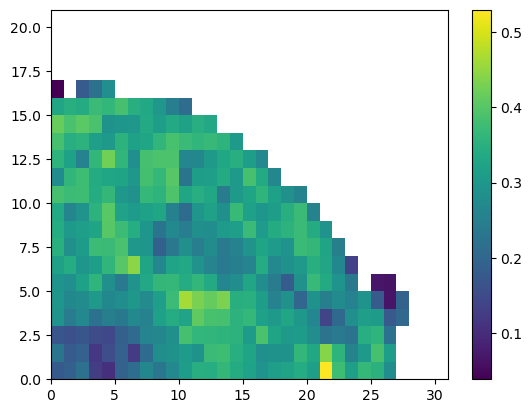

In [5]:
plt.pcolormesh(BSS)
plt.colorbar()

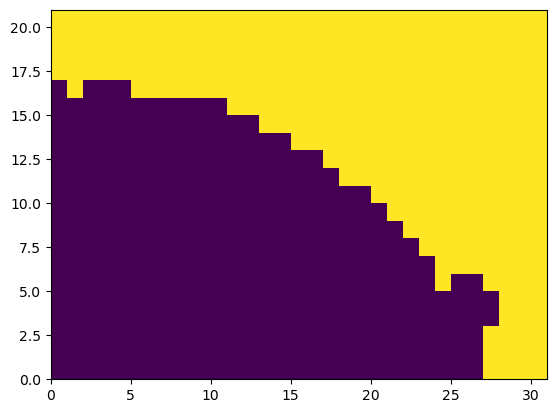

In [6]:
plt.pcolormesh(np.isnan(BSS))

In [7]:
ffor

<xarray.Dataset> Size: 6MB
Dimensions:     (latitude: 21, longitude: 31, init_month: 12, init_year: 30,
                 percentile: 3)
Coordinates:
  * latitude    (latitude) float32 84B 45.0 46.0 47.0 48.0 ... 63.0 64.0 65.0
  * longitude   (longitude) float32 124B 210.0 211.0 212.0 ... 238.0 239.0 240.0
    leadtime    int64 8B ...
  * init_month  (init_month) <U2 96B '01' '02' '03' '04' ... '09' '10' '11' '12'
  * init_year   (init_year) int64 240B 1991 1992 1993 1994 ... 2018 2019 2020
  * percentile  (percentile) float64 24B 0.8 0.9 0.95
Data variables:
    sst_an_dt   (percentile, latitude, longitude, init_month, init_year) float64 6MB ...